In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

## Reading data

In [3]:
batch_size = 32
img_height = 128
img_width = 128
seed = 42
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
SEED=42



tf.random.set_seed(SEED)

directory = '/kaggle/input/alzheimer-mri-dataset/Dataset'

train_dataset = image_dataset_from_directory(directory=directory,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=SEED)

full_validation_dataset = image_dataset_from_directory(directory=directory,
                                                       label_mode='categorical',
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE,
                                                       shuffle=True,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=SEED)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


## Splitting validation and testing datasets

<h4> As we see, the number of full_validation_dataset batches is 40 batch.  </h4>
<h4> And we want to split it into validation and testing datasets each of size 20 batch. </h4>

In [4]:
validation_batches = len(full_validation_dataset)
print(f'Total number of full_validation_dataset batches : {validation_batches}')

validation_dataset = full_validation_dataset.take(validation_batches // 2)
test_dataset = full_validation_dataset.skip(validation_batches // 2)

print(f'Number of batches in validation dataset : {len(validation_dataset)}')
print(f'Number of batches in test dataset : {len(test_dataset)}')

Total number of full_validation_dataset batches : 40
Number of batches in validation dataset : 20
Number of batches in test dataset : 20


In [5]:
class_names = train_dataset.class_names
class_names

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

## Exploring some samples

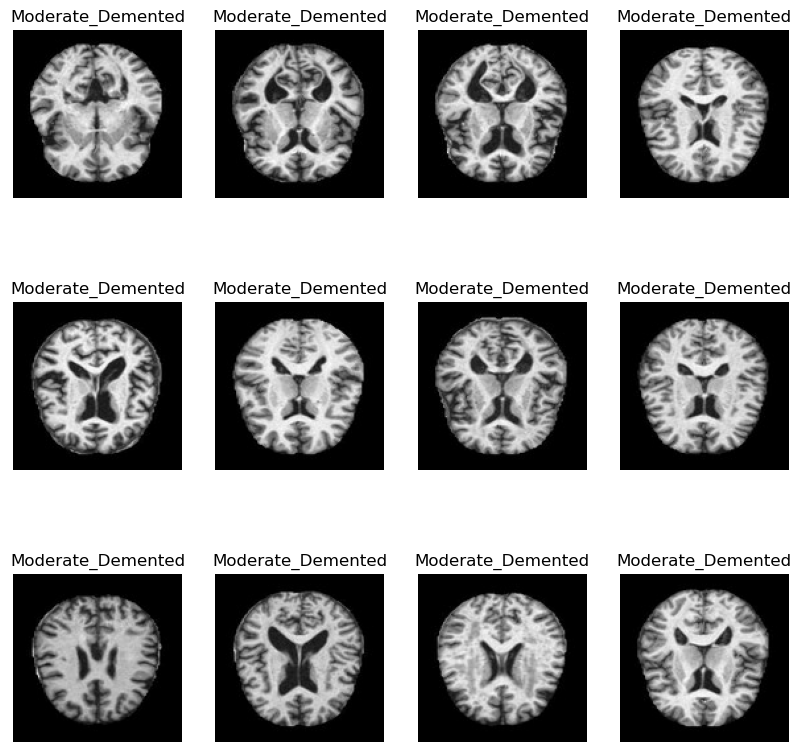

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(max(labels[i]))])
        plt.axis('off')

## Preventing a memory bottleneck
<h4> prefetch() function is used to prevent a memory bottleneck that can occur when reading from disk.</h4>
<h4> we use <b>tensorflow.data.experimental.AUTOTUNE</b> to choose the parameters automatically. </h4>

In [7]:
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [8]:
def data_augmentar():
    """This function applies two data augmentation techniques.
        First, augmentation with RandomRotation.
        Second, augmentation with RandomZoom
    """
    
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation

In [9]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

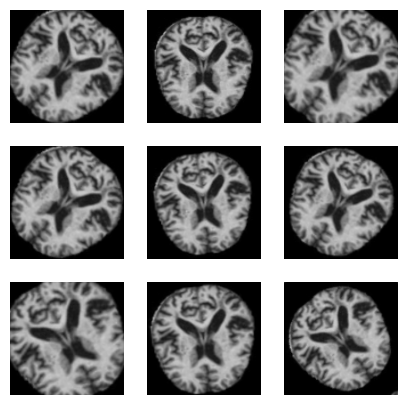

In [10]:
## applying data augmentation with a sample image.

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(image)
        plt.imshow(augmented_image.numpy().astype('uint8'), cmap='gray')
        plt.axis('off')

## Solving Imbalanced Data Problem

In [11]:
## Calculate number of samples in each class.

class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(directory+'/'+folder))

class_counts

{'Mild_Demented': 896,
 'Moderate_Demented': 64,
 'Non_Demented': 3200,
 'Very_Mild_Demented': 2240}

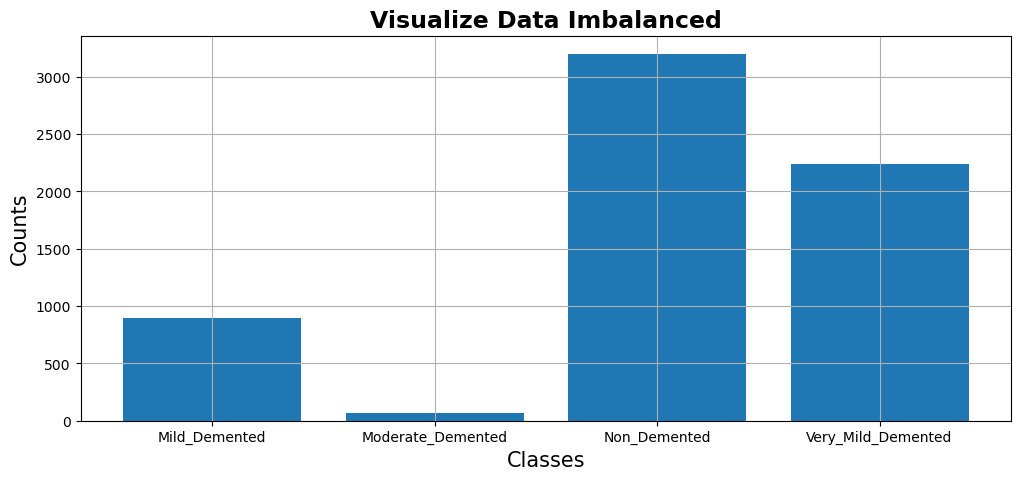

In [12]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [13]:
## Calculate class weights.

total = sum(class_counts.values())
number_of_classes = len(class_counts)

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.0
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.71


In [14]:
preprocess_input = applications.efficientnet.preprocess_input

In [ ]:
# model = applications.EfficientNetB0(include_top=False)
# len(model.layers)

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# # Define the sequential model
# model = Sequential()

# # Add convolutional layers
# model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 1)))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# # Flatten the output before passing it to the fully connected layers
# model.add(Flatten())

# # Add fully connected layers
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Print the model summary
# model.summary()


In [ ]:
# def alzheimer_classifier(image_shape=IMG_SIZE, data_augmentation=data_augmentar()):
#     """This function creates a classifier for Alzheimer disease MRI images.
    
#     Arguments:
#         image_shape-> the size of the image in the form (height, width).
#         data_augmentation-> the data augmentation object to apply on the training data.
        
#     Returns:
#         model-> the created classifier.
#     """
#     IMG_SHAPE = image_shape + (3,)
#     base_model = applications.EfficientNetB0(input_shape=IMG_SHAPE,
#                                              include_top=False, 
#                                              weights='imagenet')
    
#     base_model.trainable = True
#     for layer in base_model.layers[0:218]:
#         layer.trainable = False
    
#     inputs = Input(shape=IMG_SHAPE)
#     x = data_augmentation(inputs)
#     x = preprocess_input(inputs)
#     x = base_model(x)
#     x = GlobalAveragePooling2D()(x)
#     outputs = Dense(units=4, activation = "softmax")(x)
    
#     model = Model(inputs, outputs)
    
#     return model

In [ ]:
# def alzheimer_classifier(image_shape=IMG_SIZE, data_augmentation=data_augmentar()):
#     """This function creates a classifier for Alzheimer disease MRI images using features extracted by EfficientNetB0.
    
#     Arguments:
#         image_shape-> the size of the image in the form (height, width).
#         data_augmentation-> the data augmentation object to apply on the training data.
        
#     Returns:
#         model-> the created classifier.
#     """
#     IMG_SHAPE = image_shape + (3,)
#     base_model = applications.EfficientNetB0(input_shape=IMG_SHAPE,
#                                              include_top=False, 
#                                              weights='imagenet')
    
#     base_model.trainable = False
    
#     inputs = Input(shape=IMG_SHAPE)
#     x = data_augmentation(inputs)
#     x = preprocess_input(inputs)
#     x = base_model(x)
#     x = GlobalAveragePooling2D()(x)
    
#     # Define the sequential model to train on extracted features
#     model = Sequential()
#     model.add(Dense(512, activation='relu', input_shape=(1280,)))
#     model.add(Dropout(0.5))
#     model.add(Dense(4, activation='softmax'))
    
#     # Combine the two models into a single model
#     combined_model = Model(inputs, model(x))
    
#     # Compile the model
#     combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
#     return combined_model


In [ ]:
from keras.applications import ResNet50


In [15]:
def attention_block(x, inter_channel):
    # Channel attention
    g = GlobalAveragePooling2D()(x)
    g = Dense(inter_channel//8, activation='relu')(g)
    g = Dense(inter_channel, activation='sigmoid')(g)
    g = Reshape((1, 1, inter_channel))(g)
    
    # Spatial attention
    m = GlobalMaxPooling2D()(x)
    m = Dense(inter_channel//8, activation='relu')(m)
    m = Dense(inter_channel, activation='sigmoid')(m)
    m = Reshape((1, 1, inter_channel))(m)
    
    a = add([g, m])
    a = Activation('sigmoid')(a)
    
    x = multiply([a, x])
    return x


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GaussianNoise
num_classes=4
# img_height=128

def alzheimer_classifier(img_width, img_height, num_classes):
    # Define the input layer
    input_layer = Input(shape=(img_width, img_height, 3))

    # Add normalization and Gaussian noise layers to the input
    normalization_layer = tf.keras.layers.Rescaling(scale=1./255)
    gaussian_noise = GaussianNoise(0.15)(input_layer)
    branch_1 = normalization_layer(gaussian_noise)

    # Convolutional layers
    branch_1 = Conv2D(32, (3,3), padding='same', activation="relu")(branch_1)
    branch_1 = BatchNormalization()(branch_1)
    branch_1 = MaxPooling2D((2, 2))(branch_1)

    branch_1 = Conv2D(64, (3,3), padding='same', activation="relu")(branch_1)
    branch_1 = BatchNormalization()(branch_1)
    branch_1 = MaxPooling2D((2, 2))(branch_1)

    branch_1 = Conv2D(128, (3,3), padding='same', activation="relu")(branch_1)
    branch_1 = BatchNormalization()(branch_1)
    branch_1 = MaxPooling2D((2, 2))(branch_1)

    branch_1 = Conv2D(64, (3,3), padding='same', activation="relu")(branch_1)
    branch_1 = BatchNormalization()(branch_1)
    branch_1 = MaxPooling2D((2, 2))(branch_1)

    # Flatten and dense layers
    branch_1 = Flatten()(branch_1)
    branch_1 = Dense(256, activation='relu')(branch_1)
    branch_1 = Dense(128, activation='relu')(branch_1)
    branch_1 = Dropout(0.5)(branch_1)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(branch_1)

    # Create and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model


In [20]:
# aalzheimer_model = alzheimer_classifier(IMG_SIZE, IMG_SIZE, num_classes)
alzheimer_model = alzheimer_classifier(img_width, img_height, num_classes)




In [21]:
alzheimer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 128, 128, 3)      0         
 se)                                                             
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0     

In [22]:
lr = 0.0001
alzheimer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [23]:
history = alzheimer_model.fit(train_dataset, 
                              validation_data = validation_dataset,
                              epochs = 100,
                              class_weight=class_weights,
                              use_multiprocessing=True)

Epoch 1/100
160/160 [==============================] - 35s 110ms/step - loss: 1.5100 - accuracy: 0.3225 - val_loss: 1.2154 - val_accuracy: 0.5141
Epoch 2/100
160/160 [==============================] - 7s 39ms/step - loss: 1.0340 - accuracy: 0.4355 - val_loss: 1.0610 - val_accuracy: 0.4938
Epoch 3/100
160/160 [==============================] - 6s 37ms/step - loss: 0.8139 - accuracy: 0.5133 - val_loss: 0.9655 - val_accuracy: 0.5297
Epoch 4/100
160/160 [==============================] - 6s 35ms/step - loss: 0.7064 - accuracy: 0.5633 - val_loss: 0.8247 - val_accuracy: 0.5688
Epoch 5/100
160/160 [==============================] - 6s 34ms/step - loss: 0.6013 - accuracy: 0.6230 - val_loss: 0.7145 - val_accuracy: 0.6625
Epoch 6/100
160/160 [==============================] - 6s 34ms/step - loss: 0.5396 - accuracy: 0.6658 - val_loss: 0.6640 - val_accuracy: 0.7031
Epoch 7/100
160/160 [==============================] - 6s 35ms/step - loss: 0.4718 - accuracy: 0.7078 - val_loss: 0.6483 - val_accurac

In [25]:
test_loss, test_accuracy = alzheimer_model.evaluate(test_dataset)

print(f'Test Loss = {test_loss:.2f}')
print(f'Test Accuracy = {test_accuracy:.2f}')

20/20 [==============================] - 1s 24ms/step - loss: 0.1136 - accuracy: 0.9703
Test Loss = 0.11
Test Accuracy = 0.97


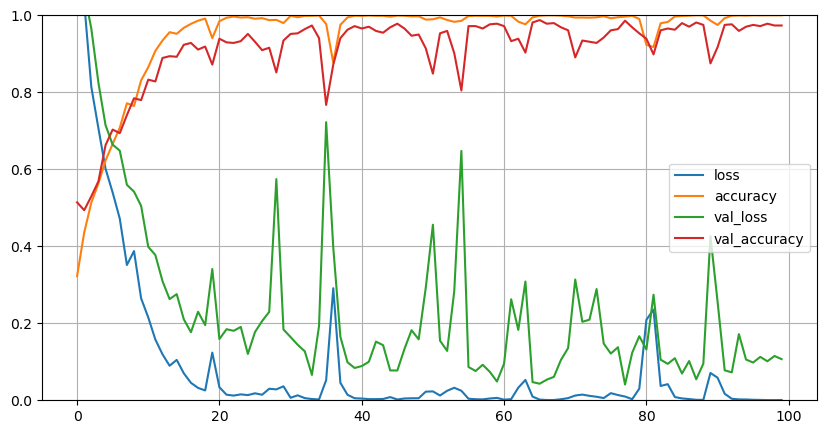

In [26]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()